# DSCI 100 Proposal

**Research question:** How accurately can we diagnose chest pain (categorised as typical angina, non-typical angina, asymptomatic) for Swiss patients based on their resting heart rate and blood pressure?

## Introduction

Chest pain encompasses discomfort such as tightness, pressure, or fullness in the chest region. This study focuses on Angina, a type of chest pain linked to coronary heart disease, resulting from insufficient blood supply to the heart due to irregular blood pressure and/or heart rate. Angina is classified into typical and non-typical forms, with typical angina exhibiting predictable pain lasting up to 10 minutes, while non-typical angina lacks a discernible pattern. Recognizing these variations is vital for prescribing suitable medication and evaluating the condition's severity, particularly to distinguish it from potential heart attacks. Thus, our research aims to determine the best recall for diagnosing chest pain (classified as typical angina, non-typical angina, and asymptomatic chest pain) in Swiss patients based on their resting heart rate and blood pressure. We prioritize recall over precision because patients with rare cases of Angina must be diagnosed and properly treated, as it can be life-saving. To address our inquiry we will analyze a dataset containing health records of a specified sample size of Swiss patients, categorizing their chest pain as anginal, non-anginal and asymptomatic chest pain based on observed resting heart rate and blood pressure.

## Preliminary exploratory data analysis

### Reading and wrangling data

After downloading the folder from the archive and storing it in a folder named "data", we read the “processed_switzerland.data” file (read_csv as it uses commas as its separator). We mutate the variable cp (chest pain) as a factor, recode its values to their respective chest pain types, and convert our two main variables into doubles (trestbps and thalrest; removed missing cases from trestbps). Note that our data is already tidy, so no wrangling was needed.

In [25]:
library(tidyverse)
library(repr)
library(tidymodels)

In [26]:
heart_disease <- read_csv("data/processed.switzerland.data",
                            col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalrest", 
                                          "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
# cp       -> chest pain
# trestbps -> resting blood pressure
# thalach  -> max heart rate achieved
    mutate(cp = as_factor(cp)) |>
    mutate(cp = fct_recode(cp, "typical_angina" = "1", "atypical_angina" = "2", "non_anginal" = "3", "asymptomatic" = "4")) |>
    filter(cp != "non_anginal") |> #We will not cover non_anginal chest pains. 
    mutate(trestbps = as.numeric(trestbps),
           thalrest = as.numeric(thalrest)) |>
    filter(trestbps != "NA")
    
heart_disease

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalrest, exang, oldpeak, slope, ca, thal
dbl (5): age, sex, cp, chol, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = as.numeric(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


age,sex,cp,trestbps,chol,fbs,restecg,thalrest,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
32,1,typical_angina,95,0,?,0,127,0,.7,1,?,?,1
34,1,asymptomatic,115,0,?,?,154,0,.2,1,?,?,1
36,1,asymptomatic,110,0,?,0,125,1,1,2,?,6,1
38,0,asymptomatic,105,0,?,0,166,0,2.8,1,?,?,2
38,0,asymptomatic,110,0,0,0,156,0,0,2,?,3,1
38,1,asymptomatic,135,0,?,0,150,0,0,?,?,3,2
38,1,asymptomatic,150,0,?,0,120,1,?,?,?,3,1
40,1,asymptomatic,95,0,?,1,144,0,0,1,?,?,2
41,1,asymptomatic,125,0,?,0,176,0,1.6,1,?,?,2


### Summarizing data

We split the data, and compute a few relevant statistics of our data, such as: average resting heart rate, average blood pressure, counts, and the percentage of each type of chest pain.

In [139]:
#set the seed to make our splits consistent, and thereby reproducible
set.seed(3)

#splitting the data for later cross-validation
heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = cp)
heart_training <- training(heart_disease_split)
heart_testing <- testing(heart_disease_split)

#summarizing training data
heart_disease_summary <- heart_training |>
    group_by(cp) |>
    summarise(avg_trestbps = mean(trestbps),
              avg_thalrest = mean(thalrest),
              count = n(),
              percent = 100 * n() / nrow(heart_training))
heart_disease_summary

cp,avg_trestbps,avg_thalrest,count,percent
<fct>,<dbl>,<dbl>,<int>,<dbl>
typical_angina,118.3333,134.6667,3,3.846154
atypical_angina,125.0000,107.5000,2,2.564103
asymptomatic,128.9041,122.2329,73,93.589744


### Visualization 

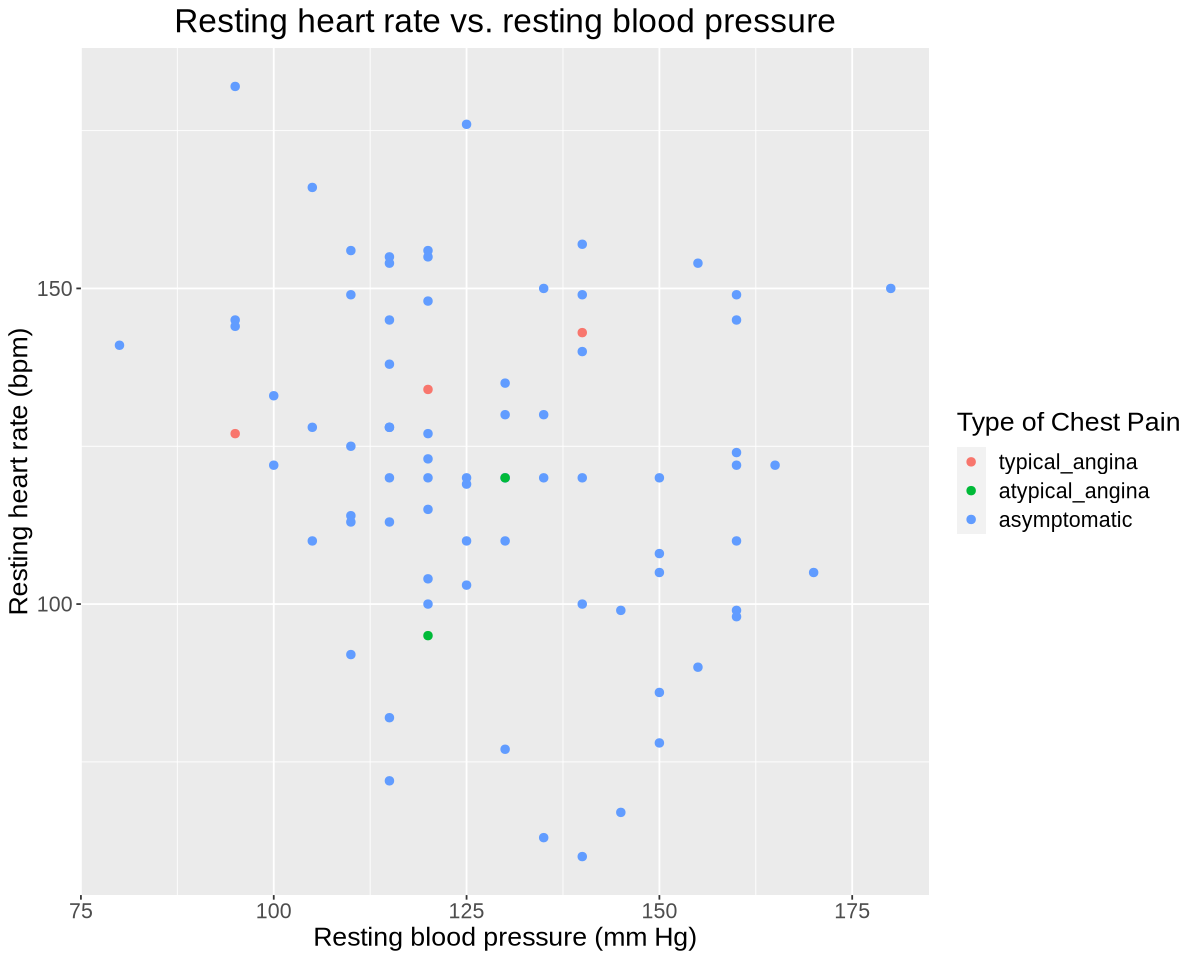

In [140]:
options(repr.plot.width = 10, repr.plot.height = 8)
heart_disease_viz <- heart_training |>
 ggplot(aes(x = trestbps, y = thalrest, colour = cp)) + 
 geom_point(size = 2) +
 ggtitle("Resting heart rate vs. resting blood pressure") +
 theme(text = element_text(size = 16), plot.title = element_text(size = 20, hjust = 0.5)) +
 labs(x = "Resting blood pressure (mm Hg)", y = "Resting heart rate (bpm)",
      color = "Type of Chest Pain")

heart_disease_viz

## Methods

We will use the k-nn classification to create a model that predicts the type of chest pain (atypical angina, typical angina, or asymptomatic) of a random observation using two predictors: resting heart rate and blood pressure. Due to smaller number of typical and atypical angina, we will have to use oversampling to resolve the class imbalance. Next, we will tune our model for the best number of neighbors using the standard tuning procedure and a scatterplot of the number of neighbors against vs estimated recall (possibly another graph plotting the number of neighbors vs estimated accuracy). We will also be applying some other statistical measures such as accuracy and precision. Finally, we will re-plot resting heart rate vs. resting blood pressure with new real observations to visualize how our model predicts them, and give a qualitative assesment of our model's overall performance.

**Variables:** 

- *Prediction Variable*: Typical angina, non-typical angina, or asymptomatic 
- *Observation Variable 1*: Resting Blood pressure
- *Observation Variable 2*: Resting Heart rate

## Expected outcomes and significance

The classifier will predict the type of chest pain based on a range: 
- Heart rate <60, blood pressure >140/90 mm Hg, means non-typical
- Heart rate >120, blood pressure >140/90 mm Hg, means typical 
- Heart rate between 60-120, blood pressure >140/90 mm Hg, means asymptomatic

Being able to properly diagnose the type of chest pain a patient has based on heart rate and blood pressure is significant because it makes their pain measurable. Proper identification of the type of chest pain gives healthcare workers the ability to efficiently treat patients with the proper medication and can also reveal possible future risks of more serious cardiovascular issues. Knowing these risks can help patients and doctors plan accordingly. 

*Sources: UpToDate. (2024). Uptodate.com. https://www.uptodate.com/contents/chest-pain-beyond-the-basics. 
 In-text citation: (UpToDate, 2024)*